In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ESN_Main_Raw import ESN
import seaborn as sns
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.simplefilter('ignore')
%matplotlib notebook
plt.style.use('dark_background')
plt.rc("figure", figsize=(8, 5))
plt.rc("savefig", dpi=90)

login = 31238461
password = 'here2makemoney@J'
server = 'Deriv-Demo'

# Initialize and login to MT5
if not mt5.initialize():
    print("initialize() failed")
    mt5.shutdown()
else:
    print("MetaTrader5 initialized")

login_result = mt5.login(login, password, server)
if login_result:
    print("Login successful")
else:
    print("Login failed. Error code:", mt5.last_error())

# Trading Logic
symbol = 'BTCUSD'
volume = 0.5

# Set start and end dates for history data
end_date = datetime.now()
start_date = end_date - timedelta(days=360)
print("data start date=", start_date)
print("data end date=", end_date)

C:\Users\UBONG\anaconda3\ANACONDA3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\UBONG\anaconda3\ANACONDA3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\UBONG\anaconda3\ANACONDA3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


MetaTrader5 initialized
Login successful
data start date= 2023-08-10 20:00:46.917484
data end date= 2024-08-04 20:00:46.917484


In [2]:
# Define timeframes to fetch
timeframes = {
    '15M': mt5.TIMEFRAME_M15,
    '1H': mt5.TIMEFRAME_H1,
    '4H': mt5.TIMEFRAME_H4,
    'Daily': mt5.TIMEFRAME_D1,
    'Weekly': mt5.TIMEFRAME_W1,
}

# Function to fetch data for a given timeframe
def fetch_data(symbol, timeframe, start_date, end_date):
    """
  Fetches historical price data for the specified symbol and timeframe.

  Args:
    symbol: The symbol of the financial instrument.
    timeframe: The desired timeframe for the data.
    start_date: The start date of the data range.
    end_date: The end date of the data range.

  Returns:
    A pandas DataFrame containing the fetched data.
  """
    
    data = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    if data is None or len(data) == 0:
        print(f"No data fetched for {symbol} at timeframe {timeframe}")
        return pd.DataFrame()
    
    df = pd.DataFrame(data)
    if 'time' not in df.columns:
        print(f"Dataframe columns: {df.columns}")
        print(f"Dataframe head: {df.head()}")
        raise KeyError('Expected column "time" not found in the dataframe')
    
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    return df

# Fetch data for each timeframe
data_frames = {tf: fetch_data(symbol, tf_code, start_date, end_date) for tf, tf_code in timeframes.items()}

Forecasted future prices:
Forecasted price for 15M: 58756.85567412023 (0.05%)
Forecasted price for 1H: 58553.611829663925 (-0.30%)
Forecasted price for 4H: 59067.34944961208 (0.58%)
Forecasted price for Daily: 60378.52516027347 (2.81%)
Real-time prices:
Real-time price for 15M: 58631.638
Real-time price for 1H: 58631.638
Real-time price for 4H: 58631.638
Real-time price for Daily: 58631.638
Real-time price for Weekly: 58631.638


<IPython.core.display.Javascript object>


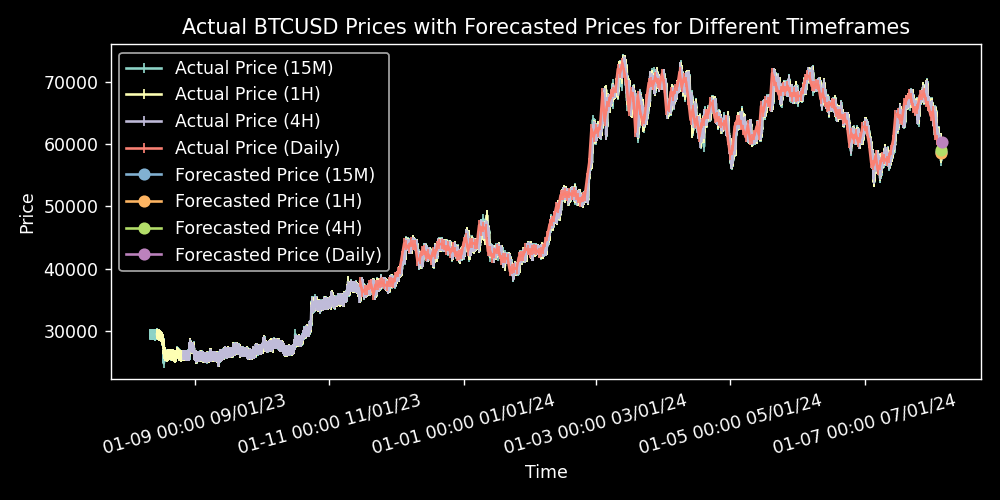

Timeframe: 15M
Mean Absolute Error (MAE): 85.67061808257355
Mean Squared Error (MSE): 20493.375650875016
Mean Absolute Percentage Error (MAPE): 0.1651071059886183%


Timeframe: 1H
Mean Absolute Error (MAE): 168.355301650474
Mean Squared Error (MSE): 78397.96023241457
Mean Absolute Percentage Error (MAPE): 0.3239279638008519%


Timeframe: 4H
Mean Absolute Error (MAE): 347.66934173533684
Mean Squared Error (MSE): 312322.7781227367
Mean Absolute Percentage Error (MAPE): 0.6582672065493773%


Timeframe: Daily
Mean Absolute Error (MAE): 1147.095688212928
Mean Squared Error (MSE): 2584975.4445792018
Mean Absolute Percentage Error (MAPE): 1.9989848928807115%




In [4]:
# FUNCTION FOR PREPROCESSING THE ENGINEERED DATA
def preprocess_data(data):
    # Log of close prices
    data['Log_Close'] = np.log(data['close'])
    
    # Returns for mu and volatility usage
    returns = data['close'].pct_change()

    # Realised mu
    realised_mu = returns.rolling(96).mean()
    data['realised_mu'] = realised_mu.dropna()

    # Realised volatility
    realised_vol = returns.rolling(94).std()
    data['realised_vol'] = realised_vol.dropna()

    return data.dropna()

# Preprocess each dataframe
preprocessed_data = {tf: preprocess_data(df) for tf, df in data_frames.items()}

# ECHO STATE NETWORK INITIALIZATION (ESN)
ESNvol = ESN(1, 1, n_reservoir=750, spectral_radius=1.0, sparsity=0, noise=.001)

# GEOMETRIC BROWNIAN MOTION (GBM)
def gbm(mu, sigma, x0, n, dt):
    step = np.exp((mu - sigma**2/2) * dt) * np.exp(sigma * np.random.normal(0, np.sqrt(dt), (1, n)))
    return x0 * step.cumprod()

# Function to train ESN on initial training data
def train_esn(train_data):
    realised_mu_train = train_data['realised_mu'].dropna()
    realised_vol_train = train_data['realised_vol'].dropna()

    for hour_volatility, hour_price, sigma, mu in zip(realised_vol_train, train_data.close, realised_vol_train, realised_mu_train):
        ESNvol.fit(np.array([np.log(hour_price) - 11]), np.array([1000 * hour_volatility]))

# Train the ESN on each timeframe's training data
train_size = 0.7
for tf, df in preprocessed_data.items():
    if len(df) > 0:
        train_data = df.iloc[:int(len(df) * train_size)]
        if len(train_data) > 0:
            train_esn(train_data)

# Forecasting future prices for each timeframe
future_forecasts = {}

for tf, df in preprocessed_data.items():
    if len(df) > 0:
        test_data = df.iloc[int(len(df) * train_size):]
        if len(test_data) > 0:
            last_price = test_data['close'].iloc[-1]
            last_sigma = test_data['realised_vol'].iloc[-1]
            last_mu = test_data['realised_mu'].iloc[-1]
            dt = {'15M': 15/1440, '1H': 1/24, '4H': 4/24, 'Daily': 1, 'Weekly': 7}[tf]
            forecast_price = gbm(last_mu, last_sigma, last_price, 1, dt)[-1]
            future_forecasts[tf] = forecast_price  # Store the future forecasted price

# Print the future forecasted prices with expected percentage values
print("Forecasted future prices:")
for tf, price in future_forecasts.items():
    last_price = preprocessed_data[tf]['close'].iloc[-1]
    expected_percentage = ((price - last_price) / last_price) * 100
    print(f"Forecasted price for {tf}: {price} ({expected_percentage:.2f}%)")

# Real-time data update function
def update_real_time_data(symbol, timeframe):
    current_data = mt5.copy_rates_from_pos(symbol, timeframe, 0, 1)
    if current_data is not None and len(current_data) > 0:
        return current_data[0]['close']
    return None

# Real-time prices for each timeframe
real_time_prices = {tf: update_real_time_data(symbol, tf_code) for tf, tf_code in timeframes.items()}

# Print the real-time prices
print("Real-time prices:")
for tf, price in real_time_prices.items():
    print(f"Real-time price for {tf}: {price}")

# Adding the forecasted points to the plot
plt.figure(figsize=(8, 4))

for tf, df in preprocessed_data.items():
    if len(df) > 0:
        plt.plot(df.index, df['close'], label=f'Actual Price ({tf})', marker='|', linestyle='-')

for tf, forecast_price in future_forecasts.items():
    forecast_time = preprocessed_data[tf].index[-1] + {'15M': timedelta(minutes=15), '1H': timedelta(hours=1),
                                                       '4H': timedelta(hours=4),'Daily': timedelta(days=1), 'Weekly': timedelta(weeks=1)}[tf]
    plt.plot([forecast_time], [forecast_price], label=f'Forecasted Price ({tf})', marker='o', linestyle='-')

# Formatting the x-axis ticks
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m %H:%M %D'))

# Labeling the axes and title
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Actual BTCUSD Prices with Forecasted Prices for Different Timeframes')

# Adding a legend
plt.legend()

# Rotating the x-axis labels for better readability
plt.xticks(rotation=15)

# Display the plot
plt.tight_layout()
plt.show()

# Function to calculate and print error metrics for a given timeframe
def calculate_error_metrics(tf, df, forecasted_price):
    if len(df) > 0:
        actual_prices = df['close'].iloc[:-1]  # actual prices excluding the last value
        predicted_prices = df['close'].shift(-1).dropna()  # predicted prices excluding the first value

        # Calculate error metrics
        mae = mean_absolute_error(actual_prices, predicted_prices)
        mse = mean_squared_error(actual_prices, predicted_prices)
        rmse = np.sqrt(mse)

        # Calculate error metrics as percentages
        actual_price_array = np.array(actual_prices)
        predicted_price_array = np.array(predicted_prices)
        percentage_error = np.abs((actual_price_array - predicted_price_array) / actual_price_array) * 100

        # Mean Percentage Error (MPE) and Mean Absolute Percentage Error (MAPE)
        mpe = np.mean((actual_price_array - predicted_price_array) / actual_price_array) * 100
        mape = np.mean(percentage_error)

        # Print the error metrics
        print(f"Timeframe: {tf}")
        print(f"Mean Absolute Error (MAE): {mae}")
        print(f"Mean Squared Error (MSE): {mse}")
#         print(f"Root Mean Squared Error (RMSE): {rmse}")
#         print(f"Mean Percentage Error (MPE): {mpe}%")
        print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
        print("\n")

# Calculate and print error metrics for all timeframes
for tf, df in preprocessed_data.items():
    if tf in future_forecasts:
        forecasted_price = future_forecasts[tf]
        calculate_error_metrics(tf, df, forecasted_price)